In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import h3
import datetime
import os
import random
import shap  

In [147]:
import json

h3_l7_df = pd.read_json("h3_l7_df.json", orient="records", lines=True)

In [148]:
# 設定plt環境
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [149]:
# 設定訓練、驗證和測試集的比例
train_proportion = 0.6   # 60% 的數據用於訓練
valid_proportion = 0.2   # 20% 的數據用於驗證
test_proportion = 0.2    # 20% 的數據用於測試

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
normalized_h3_l7_df = h3_l7_df.drop('id', axis=1)
normalized_h3_l7_df = normalized_h3_l7_df.drop('police', axis=1)

# 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_h3_l7_df = (normalized_h3_l7_df - normalized_h3_l7_df.min()) / (normalized_h3_l7_df.max() - normalized_h3_l7_df.min())

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_h3_l7_df).astype(np.float64)

# 定義批量大小，用於每次模型訓練時取樣的數據量
batch_size = 100

In [150]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [151]:
window_size = 1

In [152]:
train_size = int(spatial_data.shape[0]*0.7)

seed = 666
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

h3_l7_id = np.random.choice(spatial_data.shape[0], spatial_data.shape[0])
spatial_data = spatial_data[h3_l7_id]
train_spatial_data = spatial_data[:train_size, :]
test_spatial_data = spatial_data[train_size:, :]

In [153]:
def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)

        # s_net 輸入特徵向量並計算輸出
        # s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])))

        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        # loss.backward()
        autograd.backward(loss)

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-3, weight_decay=1e-5)

iter_num=30000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)

100%|██████████| 30000/30000 [00:30<00:00, 988.14it/s] 


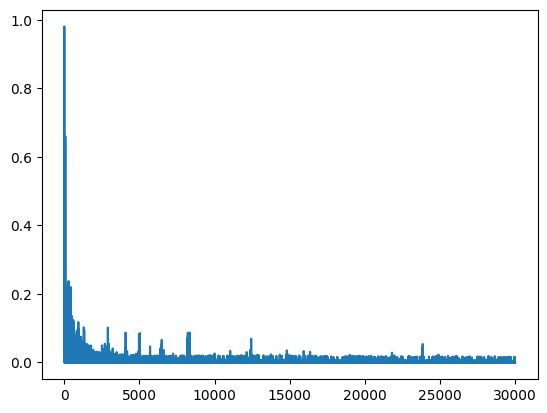

In [154]:
plt.plot(np.array(loss_array).reshape(iter_num))

In [155]:
y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*h3_l7_df.ohca.max()
y_train = train_spatial_data[:, -1]*h3_l7_df.ohca.max()
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*h3_l7_df.ohca.max()
y_test = test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()


Text(0, 0.5, 'Reality')

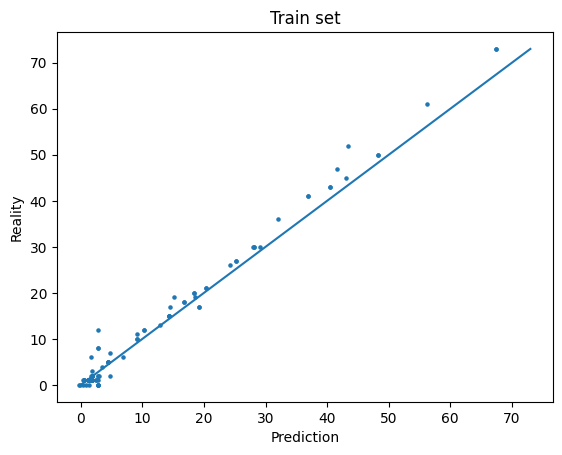

In [156]:
plt.scatter(y_head_train,
            y_train,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Train set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Reality')

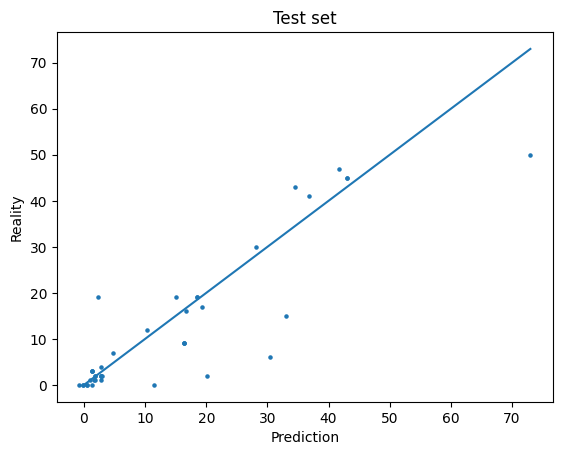

In [157]:
plt.scatter(y_head_test,
            y_test,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Number of OHCA')

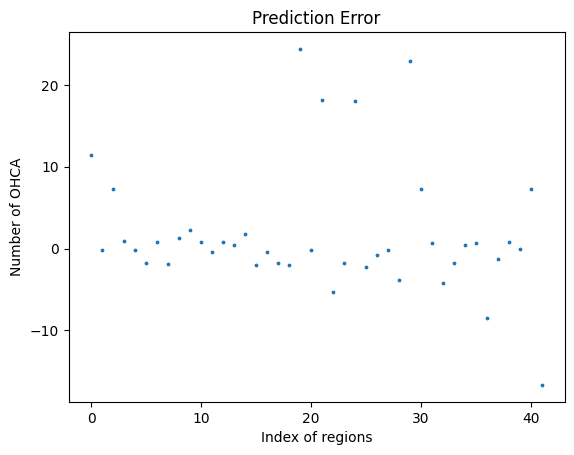

In [158]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            y_head_test- y_test,
            s = 3)
plt.title('Prediction Error')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

C:\Users\Yuan\AppData\Local\Temp\ipykernel_55112\3051722983.py:2: RuntimeWarning: divide by zero encountered in divide
  (y_head_test- y_test)/test_spatial_data[:, -1].reshape(-1, 1)/h3_l7_df.ohca.max(),


Text(0, 0.5, 'Number of OHCA')

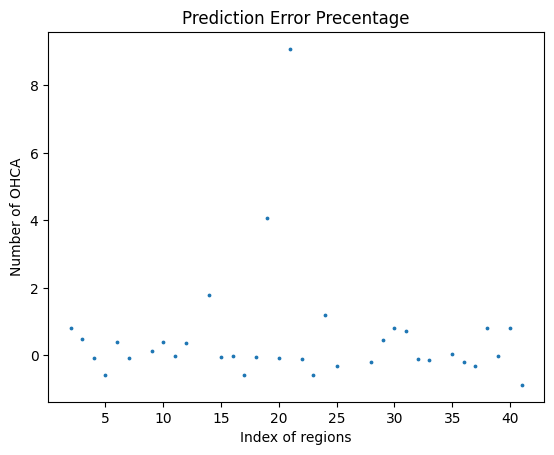

In [159]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            (y_head_test- y_test)/test_spatial_data[:, -1].reshape(-1, 1)/h3_l7_df.ohca.max(),
            s = 3)
plt.title('Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')


In [160]:
# mape_list = (y_head_test-y_test)/(test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()+1)

# mape = mape_list[mape_list != np.inf].sum()/mape_list.shape[0]

mae = np.abs(y_head_test-y_test)
mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

print("R² of test set= ", r_squared)

MAE of test set=  4.426728941854977
R² of test set=  0.7426740872354731


# SHAP

In [161]:
# 假設 `spatial_data` 包含背景數據，用於 SHAP 的解釋
background_data = torch.FloatTensor(train_spatial_data[:, :-1])  
test_data = torch.FloatTensor(test_spatial_data[:, :-1])     

In [162]:
# 建立 SHAP 解釋器，使用背景數據
explainer = shap.GradientExplainer(s_net, background_data)
shap_values = explainer.shap_values(test_data)
# Get the shap values from my test data
test_features_df = normalized_h3_l7_df.iloc[:, :-1]

feature_names = test_features_df.columns

In [163]:
shap_col = shap_values.shape[0]
shap_row = shap_values.shape[1]
shap_values.shape

(42, 51, 1)

In [164]:
shap_values_2D = shap_values.reshape(shap_col,shap_row)
shap_values_2D.shape

(42, 51)

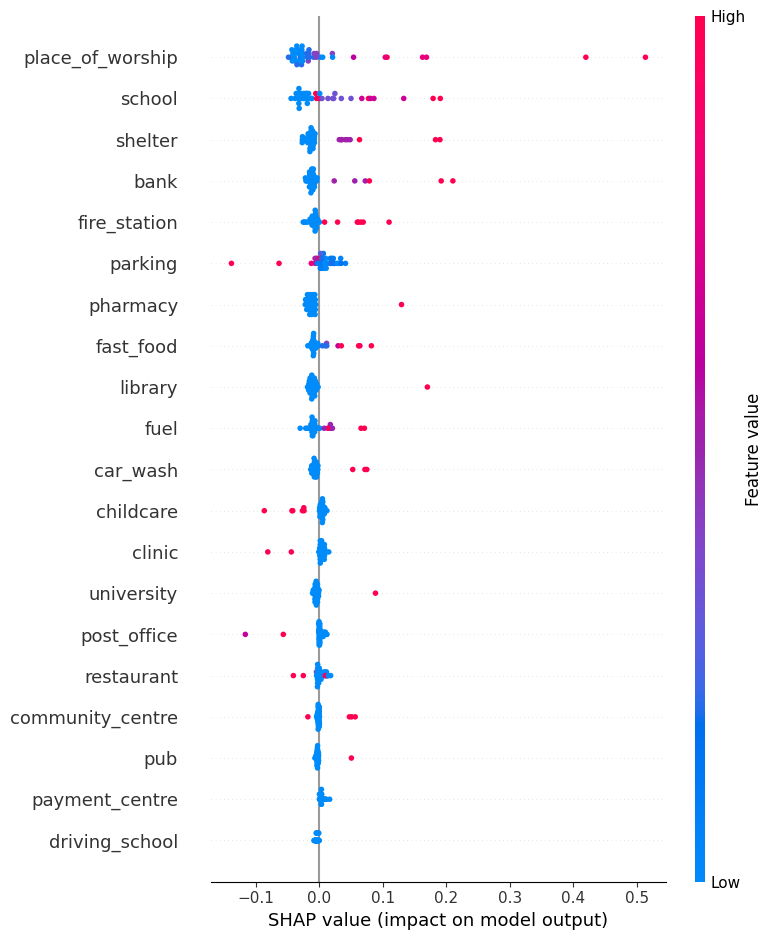

In [165]:
shap.summary_plot(shap_values_2D, test_data,feature_names)

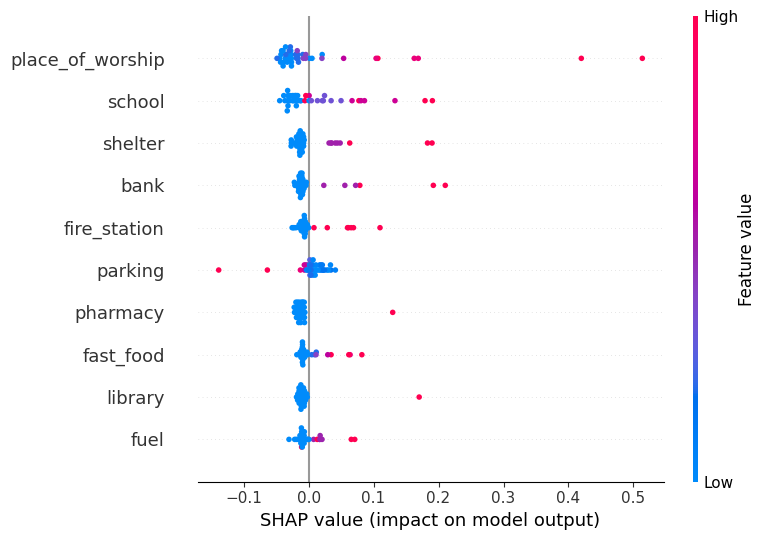

In [166]:
test_features_df = normalized_h3_l7_df.iloc[:, :-1]
feature_names = test_features_df.columns
# 計算每個特徵的平均絕對 SHAP 值
mean_shap_values = np.abs(shap_values).mean(axis=0).reshape(-1)

# 創建一個 DataFrame，用來存儲每個特徵和它的平均 SHAP 值
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean SHAP Value": mean_shap_values
})

# 按照 SHAP 值的大小排序特徵
shap_df = shap_df.sort_values(by="Mean SHAP Value", ascending=False)

# 選擇前 N 個最重要的特徵
top_feature = 10
top_n_features = shap_df.head(top_feature)  # 例如選擇前10個特徵
top_n_feature_names = top_n_features["Feature"].values

# 過濾出前 N 個特徵的 SHAP 值
filtered_shap_values = shap_values[:, shap_df.index[:top_feature]]  # 選擇對應的 SHAP 值
filtered_test_data = test_data[:, shap_df.index[:top_feature]]  # 選擇對應的特徵數據
filtered_test_data = filtered_test_data.numpy()


# 變成summary_plot可讀的格式
filtered_shap_col = filtered_shap_values.shape[0]
filtered_shap_row = filtered_shap_values.shape[1]
filtered_shap_values_2D = filtered_shap_values.reshape(filtered_shap_col,filtered_shap_row)

shap.initjs()
# 用 SHAP 的 summary_plot 可視化最相關的特徵
plt.figure(figsize=(1, 8))
shap.summary_plot(filtered_shap_values_2D, filtered_test_data,top_n_feature_names)